<a href="https://colab.research.google.com/github/JonnyElkin/Masters-Project/blob/main/Master's_Project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Master's Project v2

####Install Requirements

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import typing

import matplotlib.pyplot as plt
%matplotlib inline

import random

import torch
import torch.nn as nn
import torch.optim as optm
from torch.utils.data import TensorDataset, Dataset, DataLoader

##Getting Data

###Generating Simple Synthetic Data

In [ ]:

def get_auto_reg_features(ar_n: int, length: int, noise_level=0.05) -> list:            #use an auto regressive model to make some data
                                                                      # Predefined paramters: ar_n is Order of the AR(n) data, length is Number of data points to generate
  #Get coefficients for AR equation
  ar_coeff = list(np.random.random(ar_n)-0.5)                                                  
  
  # Random initial values
  ar_data = list(np.random.random(ar_n)-0.5)
  
  # Generate the rest of the values
  for i in range(length - ar_n):
      next_val = (np.array(ar_coeff) @ np.array(ar_data[-ar_n:])) + (np.random.random() -0.5) * noise_level
      ar_data.append(next_val)

  return ar_data

In [ ]:
def get_poly_features(length: int, degree: int, noise_level=0.05) -> list:
  coef = np.random.random(degree)-0.5              #move range from [0,1] to [-0.5, 0.5] and get random co-efficients
  poly = np.polynomial.polynomial.Polynomial(coef) #make polynomial object

  x, y = poly.linspace(length)                     #get length # of samples from polynomial function
  result = y + ((np.random.random(y.size) - 0.5) * noise_level) #return with some added noise

  
  return result

In [ ]:
def get_samples(X_underlying: np.ndarray, number: int) -> np.ndarray:  #create a random number for each samples and use this number to add noise to underlying function
  noise = np.random.random(number) 
  (a,b) = np.shape(X_underlying)

  X = np.ndarray((number, a, b))
  for i in range(number):
    X[i] = X_underlying * noise[i] *100

  return X

In [ ]:
def make_synthetic_data(num_poly: int, degrees: tuple, num_ar: int, ar_ns: tuple, length: int, num_samples: int, noise_level=0.1) -> (np.ndarray, np.ndarray):  #functin to tie use the above functions and output synthetic data
  X_underlying = np.ndarray((length, num_poly+num_ar))
  X = np.ndarray((num_samples, length, num_poly+num_ar))
  y = np.ndarray((num_samples, length))

  i=0
  while i < num_poly:
    X_underlying[:, i] = get_poly_features(length, degrees[i], noise_level)
    i+=1

  while i-num_poly < num_ar:
    X_underlying[:, i] = get_auto_reg_features(length, ar_ns[i-num_poly], noise_level)
    i+=1

  #add some random noise to avoid making a singular matrix


  X = get_samples(X_underlying, num_samples)
  y = np.matmul(X, np.ones(num_poly+num_ar)) + np.random.sample((num_samples, length))*noise_level
  
  return X,y

In [ ]:
#example use:

X, y = make_synthetic_data(2,(2,3), 3, (1,2,3), 50, 7)

y.shape
y.mean(axis=0).shape

X.shape
print(np.transpose(X, axes = [1,2,0]).shape)
print(np.transpose(y, axes = [1,0]).shape)

(50, 5, 7)
(50, 7)


###Get Iterable Synthetic Data

In [ ]:
def make_syn_iterable(X_train, y_train,  X_test,y_test, batch_size=100, n_iters=3000):
  batch_size = 100
  n_iters = 3000
  num_epochs = n_iters / (X_train.shape[1] / batch_size)
  num_epochs = int(num_epochs)

  X_train = torch.from_numpy(np.transpose(X_train, axes = [0,1,2]))
  y_train = torch.from_numpy(np.transpose(y_train, axes = [0,1]))

  X_test = torch.from_numpy(np.transpose(X_test, axes = [0,1,2]))
  y_test = torch.from_numpy(np.transpose(y_test, axes = [0,1]))

  training_data = torch.utils.data.TensorDataset(X_train , y_train)
  testing_data = torch.utils.data.TensorDataset(X_test, y_test)



  train_loader = torch.utils.data.DataLoader(dataset=training_data, 
                                            batch_size=batch_size, 
                                           shuffle=True)
  
  test_loader = torch.utils.data.DataLoader(dataset=testing_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)
  return train_loader, test_loader

make_syn_iterable(X,y,X,y)


(<torch.utils.data.dataloader.DataLoader at 0x7f85a0fc20d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f85a0a8d670>)

###Get basic ADNI Data

In [ ]:
def get_simple_ADNI():
  df = pd.read_excel("/content/D1_D2_feature_subset.xlsx", sheet_name= "Sheet1")

  subset = df[["RID","ADAS13","AGE","APOE4","CDRSB","MMSE","Hippocampus","WholeBrain"]]
  subset = subset.dropna()
  numpy_data = subset.astype("float").values

  indicies, counts = np.unique(numpy_data[:, 0], return_counts = True)

  X = np.zeros(counts.size, dtype = 'object')
  y = np.zeros(counts.size, dtype = 'object')
  counter = 0
  for i, size in enumerate(counts):
    X[i] = numpy_data[counter:counter+size , 2:]
    y[i] = numpy_data[counter:counter+size, 1:2]
    counter += size

  return X, y

###Plot Data

In [ ]:
def plot_data(X, y):

  fig, axes = plt.subplots(nrows=X.shape[1]+1, dpi=120, figsize=(10,6))
  for i, ax in enumerate(axes.flatten()):
      if i < X.shape[1]:
        data = X[:, i]
        name = "Feature ", i
      else:
        data = y
        name = "y"
      ax.plot(data, color='red', linewidth=1)
      # Decorations
      ax.set_title(name)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

  plt.tight_layout();

##Defining Models

###Mean Prediction

In [ ]:
def mean_forecast(Y, steps, data):
  if data == 'Syn':     
    mean_Y = Y.mean()
    return np.ones(steps)*mean_Y
  if data == 'ADNI':
    y_mean = 0
    for y_val in Y:
      y_mean += y_val.mean()

    y_mean = y_mean / Y.size
    return np.ones(steps)*y_mean

###Simple AutoRegressive

In [ ]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [ ]:
def simple_auto_reg_forcaset(Y, steps, lags, data):
  if data == 'Syn':
    #first, take the mean of the samples
    y_means = y.mean(axis=0)

    #fit the model to the data
    model = AutoReg(y_means, lags=lags, old_names=False).fit()

    #print(model.summary())

    forecast = model.predict(start=0, end = steps, dynamic=False)

    return forecast
  if data == 'ADNI':
    y_sums = np.zeros(11)
    y_counts = np.zeros(11, dtype='int')
    for i, y_val in enumerate(y):
      temp = np.pad(y_val, ((0,11-y_val.size),(0,0)))
      y_sums += temp[:, 0]
      y_counts += np.ones(11, dtype='int') - np.isclose(temp[:, 0], 0) *1
    y_means = y_sums / y_counts

    #fit the model to the data
    model = AutoReg(y_means, lags=lags, old_names=False).fit()

    #print(model.summary())

    forecast = model.predict(start=0, end = steps, dynamic=False)

###Vector AutoRegressive

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
def vector_auto_reg_model(X,y,lags):
  #first, take the mean of the sample
  y_means = y.mean(axis=0)
  X_means = X.mean(axis=0)

  data = np.append(X_means, np.transpose([y_means]), axis=1)
  #fit the model to the data
  model = VAR(data).fit(lags)  

  return model

def vector_auto_reg_forecast(model, X, y, steps, lags):


  data = np.append(X, np.transpose([y]), axis=1)

  forecast = model.forecast(y=data[0:lags, :], steps=steps)

  return forecast

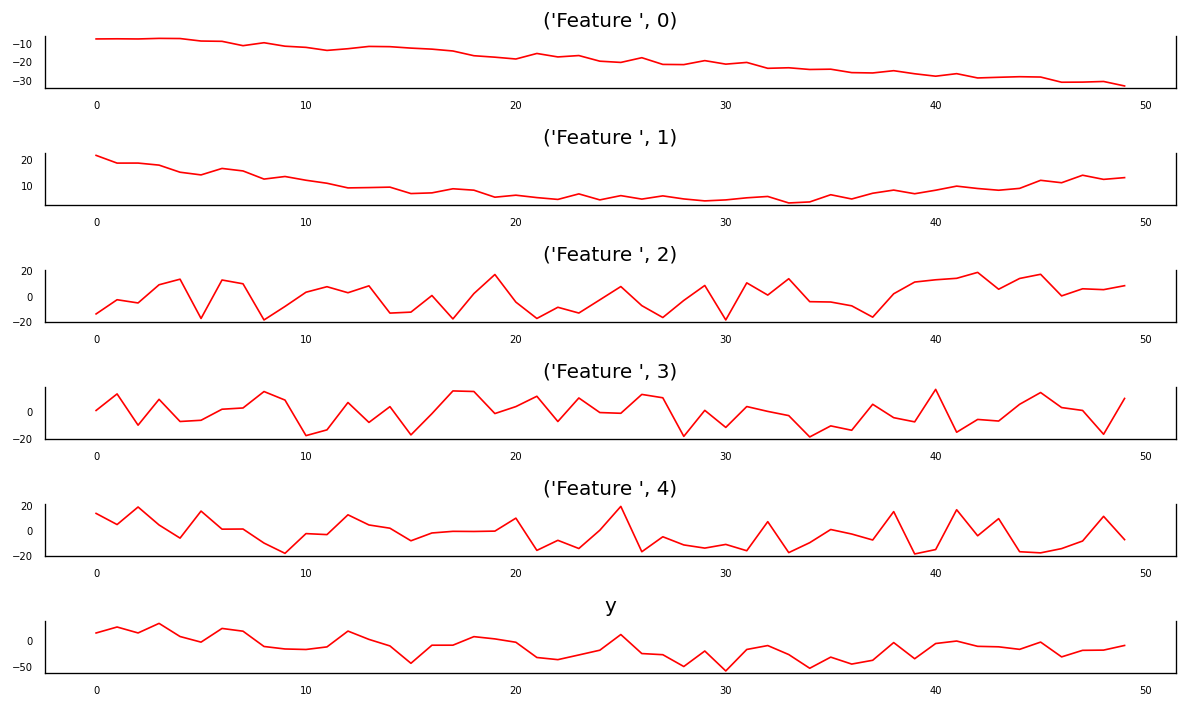

In [ ]:
#example use:

X, y = make_synthetic_data(2,(2,3), 3, (1,2,3), 50, 10)

y.shape
y_means = y.mean(axis=0)

X_means = X.mean(axis=0)

plot_data(X_means, y_means)

(50, 5)
(50,)


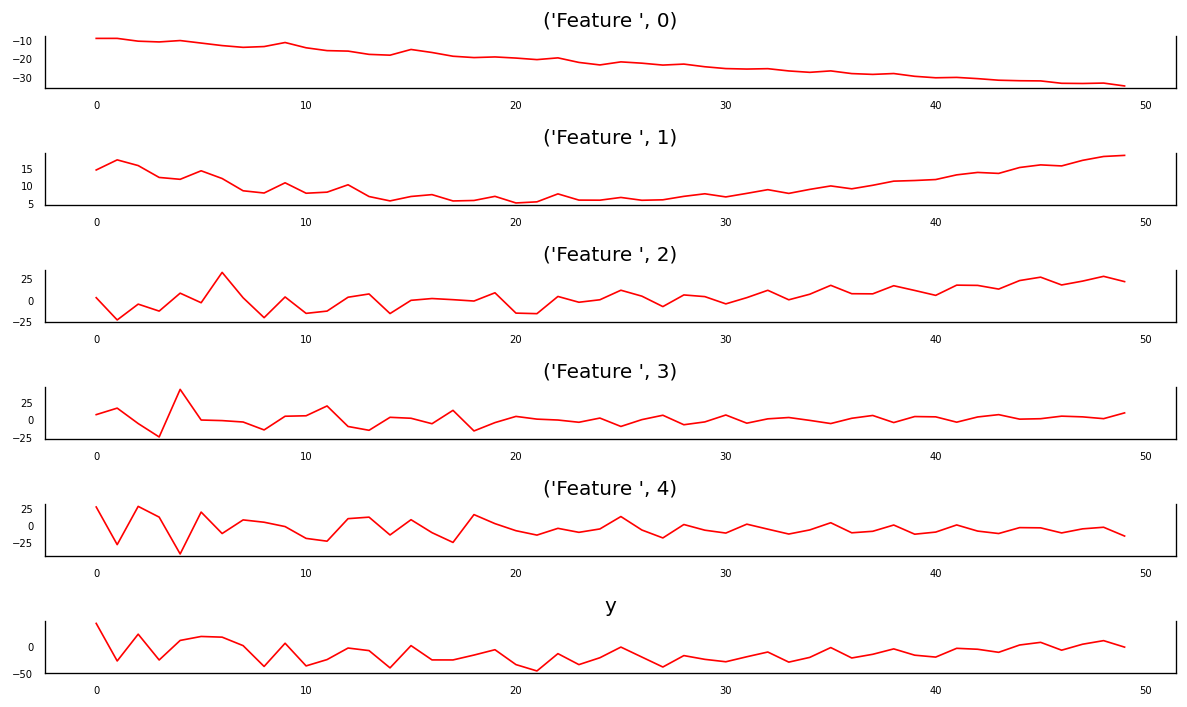

In [ ]:
model = vector_auto_reg_model(X,y,5)

data = vector_auto_reg_forecast(model, X[0],y[0], 50, 5)

print(X[0].shape)
print(y[0].shape)

data[:, 1]

plot_data(data[:, :5], data[:, 5])

###Recurrant Neural Network

####Class Def

In [ ]:
class M2M_RNNModel(nn.Module):     #many-to-many RNN
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(M2M_RNNModel, self).__init__()

    self.hidden_dim = hidden_dim    #num nodes in hidden layers
    self.num_layers = num_layers    #num of hidden layers
    self.output_dim = output_dim
    self.input_dim = input_dim

    # batch_first=True causes input/output tensors to be of shape
    # (batch_dim, seq_dim, input_dim)
    # batch_dim = number of samples per batch



    if num_layers == 0:
      self.lin = nn.Linear(input_dim, output_dim)
    else:
      self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='relu')
      self.decode = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):

    if self.num_layers == 0:
      out = self.lin(x)
    else:
      # Initialize hidden state with zeros
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

      # We need to detach the hidden state to prevent exploding/vanishing gradients
      # This is part of truncated backpropagation through time (BPTT)
    #  print("hi")
      out, hn = self.rnn(x, h0.detach())
      decoded = torch.ones((out.shape[0], out.shape[1]))  #, self.output_dim if output dim was bigger than 1, add this

      #print(out.shape)
    #  print("initial decoded:   ", decoded)
      # apply decoder to each timestep
      for i in range(out.shape[0]):
        for j in range(out.shape[1]):
        #  print(self.decode(out[i,j]))
          decoded[i,j] = self.decode(out[i,j])


    return decoded

####Training Function

In [ ]:
def train_RNN(model, train_loader, test_loader, seq_dim, input_dim, num_epochs=1): 

  criterion = nn.MSELoss()
  learning_rate = 0.0001
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

  iter = 0
  for epoch in range(num_epochs):
      for sample, labels in train_loader:
          model.train()

          # Load samples as tensors with gradient accumulation abilities
          sample = sample.view(-1, seq_dim, input_dim).requires_grad_()

          # Clear gradients w.r.t. parameters
          optimizer.zero_grad()

          # Forward pass to get output/logits    
          outputs = model(sample.float())

          # Calculate Loss
          loss = criterion(outputs, labels.float())

          # Getting gradients w.r.t. parameters
          loss.backward()

          # Updating parameters
          optimizer.step()

  return model


In [ ]:
#train_RNN(train_loader, test_loader, 10, num_epochs = 10)

##Testing Models

###Mean Squared Error

The plan is to find the MSE for each of the different models when trained on the synthetic dataset. As there is an element of random in the dataset generation, we will average over many synthetic datasets to get a more stable outcome. This will be done with poly only, AR only and mixed features in the data set.

The data will be split into testing and training data by seperating some samples from the dataset to be tested on un seen later.

In [ ]:
def mse(X, X_est):

  return np.mean((X-X_est)**2)

In [ ]:
samples = 100
epochs = 15
steps = 10
max_num_features =15

def synthetic_testing_epoch(samples=100, steps=10, min_num_features=1, max_num_features=15):
  model_mses = np.zeros((4, max_num_features))
  mean_mses = np.zeros((min_num_features,max_num_features))
  simple_ar_mses = np.zeros((min_num_features,max_num_features))
  var_mses = np.zeros((min_num_features,max_num_features))
  rnn_mses = np.zeros((min_num_features,max_num_features))

  #loop over the number of features to be included in test data
  for i in range(min_num_features, max_num_features):

    #split the i features into poly and AR
    num_poly = i//2
    num_ar = i-num_poly

    #generate the parameters needed for these
    options = [1,2,3,4]
    poly_args = random.choices(options, k = num_poly)
    ar_args = random.choices(options, k = num_ar)

    #get data
    complete_X, complete_y = make_synthetic_data(num_poly,poly_args, num_ar, ar_args, steps, samples)

    #split into training and test sets
    train_X = complete_X[:int(100*0.8)]
    train_y = complete_y[:int(100*0.8)]


    test_X = complete_X[int(100*0.8):]
    test_y = complete_y[int(100*0.8):]


  ### SIMPLE MEAN ESTIMATE SECTION
    single_mean_est = mean_forecast(train_y, steps, 'Syn')
    samples_mean_est = np.matmul(np.ones((20,10,10)), single_mean_est )                   #note that by the nature of the estimator, the guess is the same for every sample
    mean_est_mse = mse(samples_mean_est, test_y)
    mean_mses[:,i] = mean_est_mse

  #SIMPLE AUTOREGRESSION SECTION
    single_ar_est = simple_auto_reg_forcaset(train_y, steps+4, 5, 'Syn')
    samples_ar_est = np.matmul(np.ones((20,10,10)), single_ar_est )                   #note that by the nature of the estimator, the guess is the same for every sample
    ar_est_mse = mse(samples_ar_est, test_y)
    simple_ar_mses[:,i] = ar_est_mse

  #Vector AUTOREGRESSION SECTION
    var_model = vector_auto_reg_model(train_X,train_y,5)

    var_estimates = np.zeros((int(samples*0.2), steps))
    for j in range(int(samples*0.2)):
      #print(test_X[i].shape)
      #print(test_y[i].shape)

      var_forcast = vector_auto_reg_forecast(var_model, test_X[j],test_y[j], steps, 5)
      #print(var_forcast[:, -1].shape)
      var_estimates[j] = var_forcast[:, -1]
    var_mses[:,i] = mse(test_y, var_estimates)

  #RNN Section

    #get iterable data
    train_loader, test_loader = make_syn_iterable(train_X, train_y,  test_X,test_y)

    #set up model
    input_dim = i
    hidden_dim = 20
    layer_dim = 1
    output_dim = 1
    rnn_model = M2M_RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
    #train model  
    rnn_model = train_RNN(rnn_model, train_loader, test_loader, steps,input_dim, num_epochs = 10)

    #test model
    rnn_mse = 0
    j=0
    for sample, labels in test_loader:
      rnn_model.eval()
      rnn_outputs = rnn_model(sample.float())
      mean = torch.mean(((rnn_outputs - labels)**2))
      if not(torch.isnan(mean)):
        rnn_mse += mean
        j+=1
    rnn_mses[:, i] =  (rnn_mse / j).detach().numpy()

      





    ##RETURN THE MSES
  model_mses = np.concatenate((mean_mses,simple_ar_mses, var_mses, rnn_mses ), axis=0)
  return model_mses




In [ ]:
def synthetic_testing(num_epochs=50, samples=100, steps=10, max_num_features=15):
  mses = np.zeros((num_epochs, 4, max_num_features))

  for i in range(num_epochs):
    mses[i] = synthetic_testing_epoch(max_num_features = max_num_features)

  avg_mses = np.median(mses, axis=0)

  print(avg_mses.shape)

  return avg_mses

In [ ]:
def plot_mses(mses, labels, colors):

  fig, ax = plt.subplots(dpi=120, figsize=(10,6))
  ax.set_title("Model Mean Squared Errors")
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines["top"].set_alpha(0)
  ax.tick_params(labelsize=6)

  for i in range(mses.shape[0]):
    data = mses[i]
    ax.plot(data, color=colors[i], label=labels[i])

  ax.legend(loc='upper left')
  plt.tight_layout();


(4, 10)


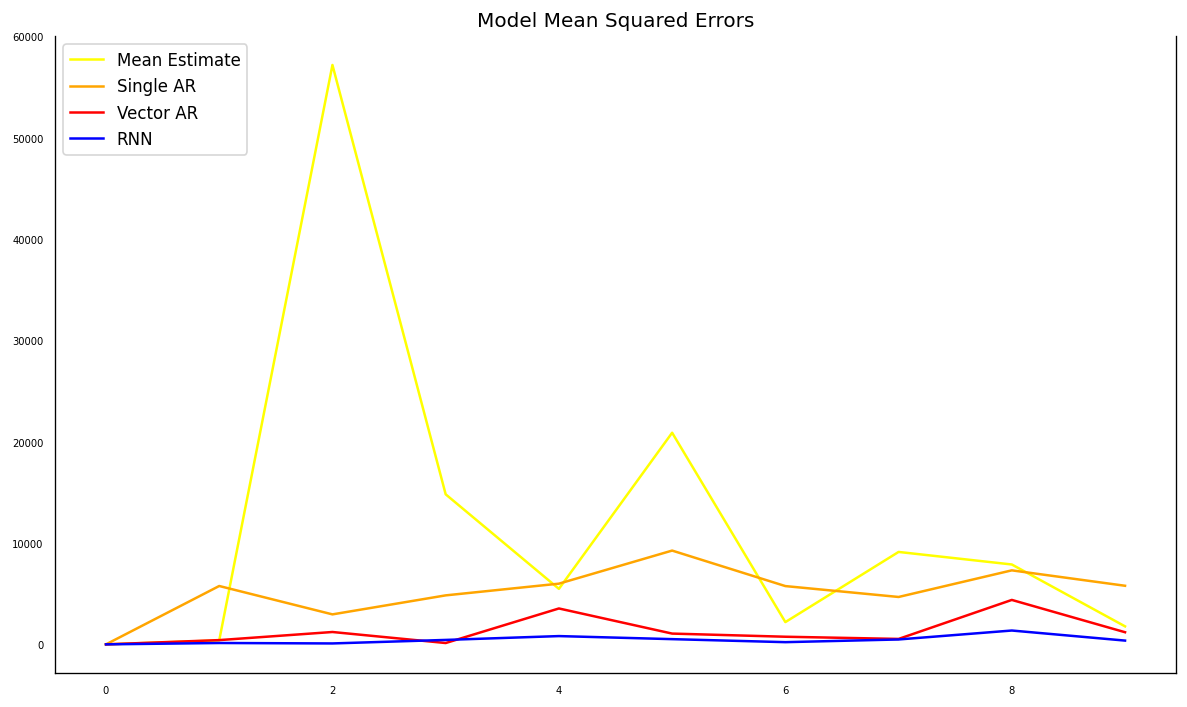

In [ ]:
mses = synthetic_testing(1, max_num_features=10)
labels = ['Mean Estimate', 'Single AR', 'Vector AR', 'RNN']
colors = ['yellow', 'orange', 'red', 'blue']

plot_mses(mses, labels, colors)

###Learning Curves

I want to get learning curves for the different models, I think I'll do this in seperate functions unlike above.

In [ ]:
#Mean estimate Learning curve
def get_mean_est_lcurve_points(train_y, test_y, num_points, data):

  epoch_size = (train_y.shape[0] // num_points)
  error = 0
  points = np.ones(num_points)
  for i in range(1, num_points+1):
    for y in test_y:
      pred = mean_forecast(train_y[0:i*epoch_size], y.size, data)
      error += mse(y, pred)
    points[i-1] = error / test_y.shape[0]

  return points


In [ ]:
#Mean estimate Learning curve
def get_ar_lcurve_points(train_y, test_y, num_points, data, lags=5):

  epoch_size = (train_y.shape[0] // num_points)
  error = 0
  points = np.ones(num_points)
  for i in range(1, num_points+1):
    for y in test_y:
      pred = simple_auto_reg_forcaset(train_y[0:i*epoch_size], y.size+lags-1, lags,data)
      error += mse(y, pred)
    points[i-1] = error / test_y.shape[0]
    print(test_y.shape[0])
  return points

In [ ]:
def plot_learning_curves(train_X, train_y, test_X, test_y, num_points, data):
  mean_points = get_mean_est_lcurve_points(train_y, test_y, num_points, data)
  uni_ar_points = get_ar_lcurve_points(train_y, test_y, num_points, data, lags=8)


  mses = np.stack((np.expand_dims(mean_points, axis=1), np.expand_dims(uni_ar_points, axis=1)), axis=0)
  print(mses)
  labels = ['Mean Estimate', 'Single AR', 'Vector AR', 'RNN']
  colors = ['yellow', 'orange', 'red', 'blue']
  plot_mses(mses, labels, colors)


20
20
20
20
20
20
20
20
20
20
[[[ 1578.55142318]
  [ 3108.1816685 ]
  [ 4627.22115616]
  [ 6143.68661782]
  [ 7660.46623565]
  [ 9185.1847294 ]
  [10711.86653487]
  [12236.72060731]
  [13764.86716052]
  [15292.24460006]]

 [[ 3850.9840575 ]
  [ 7701.96811501]
  [11552.95217251]
  [15403.93623002]
  [19254.92028752]
  [23105.90434503]
  [26956.88840253]
  [30807.87246004]
  [34658.85651754]
  [38509.84057504]]]


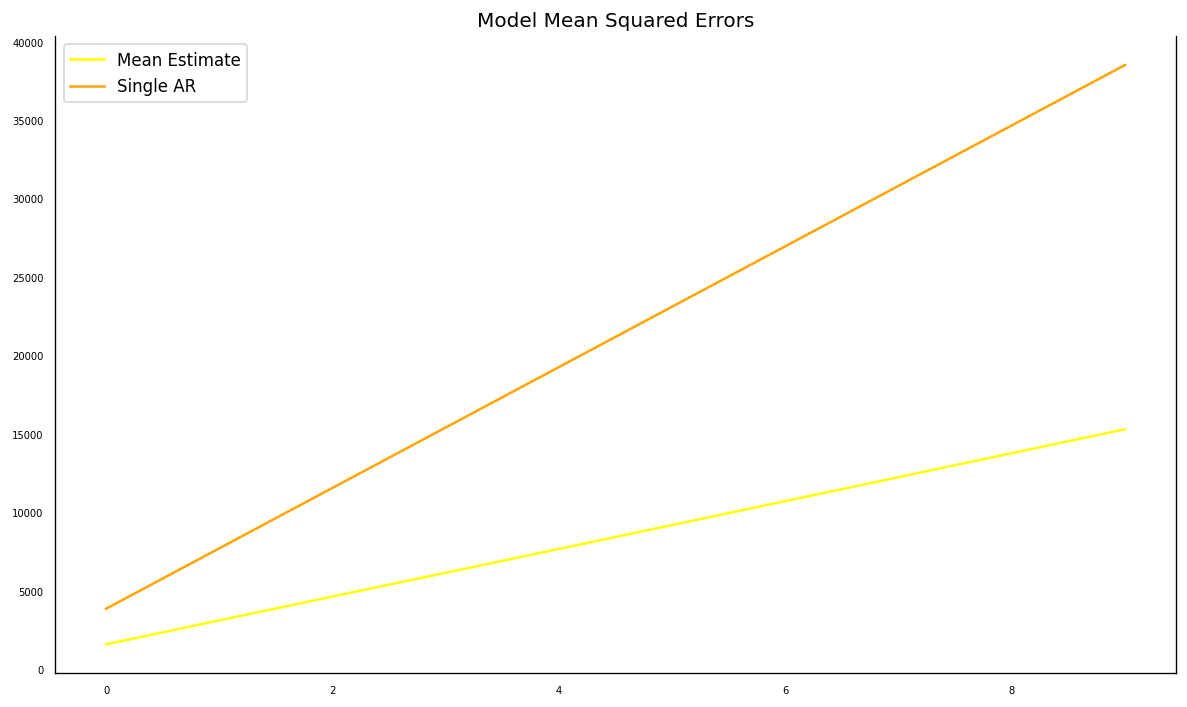

In [ ]:
#get data
complete_X, complete_y = make_synthetic_data(3, (1,2,2,3),3, (2,3,4,5), 10, 100)

#split into training and test sets
train_X = complete_X[:int(100*0.8)]
train_y = complete_y[:int(100*0.8)]


test_X = complete_X[int(100*0.8):]
test_y = complete_y[int(100*0.8):]

plot_learning_curves(train_X, train_y, test_X, test_y, 10, 'Syn')